In [1]:
!pip install scikit-survival
!pip install tensorflow==1.13.1

In [ ]:
#required modules in python:
#numpy
#matplotlib
#pandas
#scikit-survival
#tensorflow version 1.13.1

In [2]:
from typing import Any, Dict, Iterable, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.datasets import mnist

print("Using Tensorflow:", tf.__version__)
tf.logging.set_verbosity(tf.logging.WARN)

Using Tensorflow: 1.13.1


In [ ]:
#PRIMER ON SURVIVAL ANALYSIS

In [ ]:
#GENERATING SYNTHETIC SURVIVAL DATA FROM MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

y = np.concatenate((y_train, y_test))

In [4]:
def make_risk_score_for_groups(y: np.ndarray,
                               n_groups: int = 4,
                               seed: int = 89) -> Tuple[pd.DataFrame, np.ndarray]:
    rnd = np.random.RandomState(seed)

    # assign class labels `y` to one of `n_groups` risk groups
    classes = np.unique(y)
    group_assignment = {}
    group_members = {}
    groups = rnd.randint(n_groups, size=classes.shape)
    for label, group in zip(classes, groups):
        group_assignment[label] = group
        group_members.setdefault(group, []).append(label)

    # assign risk score to each class label in `y`
    risk_per_class = {}
    for label in classes:
        group_idx = group_assignment[label]
        group = group_members[group_idx]
        label_idx = group.index(label)
        group_size = len(group)

        # allow risk scores in each group to vary slightly
        risk_score = np.sqrt(group_idx + 1e-4) * 1.75
        risk_score -= (label_idx - (group_size // 2)) / 25.
        risk_per_class[label] = risk_score

    assignment = pd.concat((
        pd.Series(risk_per_class, name="risk_score"),
        pd.Series(group_assignment, name="risk_group")
    ), axis=1).rename_axis("class_label")
        
    risk_scores = np.array([risk_per_class[yy] for yy in y])
    return assignment, risk_scores


risk_score_assignment, risk_scores = make_risk_score_for_groups(y)

risk_score_assignment.round(3)

,risk_score,risk_group
class_label,,
0,3.071,3
1,2.555,2
2,0.058,0
3,1.790,1
4,2.515,2
5,3.031,3
6,1.750,1
7,2.475,2
8,0.018,0


In [5]:
class SurvivalTimeGenerator:

    def __init__(self,
                 num_samples: int,
                 mean_survival_time: float,
                 prob_censored: float) -> None:
        self.num_samples = num_samples
        self.mean_survival_time = mean_survival_time
        self.prob_censored = prob_censored

    def gen_censored_time(self,
                          risk_score: np.ndarray,
                          seed: int = 89) -> Tuple[np.ndarray,np.ndarray]:
        rnd = np.random.RandomState(seed)
        # generate survival time
        baseline_hazard = 1. / self.mean_survival_time
        scale = baseline_hazard * np.exp(risk_score)
        u = rnd.uniform(low=0, high=1, size=risk_score.shape[0])
        t = -np.log(u) / scale

        # generate time of censoring
        qt = np.quantile(t, 1.0 - self.prob_censored)
        c = rnd.uniform(low=t.min(), high=qt)

        # apply censoring
        observed_event = t <= c
        observed_time = np.where(observed_event, t, c)
        return observed_time, observed_event


surv_gen = SurvivalTimeGenerator(
    num_samples=y.shape[0],
    mean_survival_time=365.,
    prob_censored=.45
)
time, event = surv_gen.gen_censored_time(risk_scores)
time_train = time[:y_train.shape[0]]
event_train = event[:y_train.shape[0]]
time_test = time[y_train.shape[0]:]
event_test = event[y_train.shape[0]:]

print("%.2f%% samples are right censored in training data." % (np.sum(~event_train) * 100. / len(event_train)))
print("%.2f%% samples are right censored in test data." % (np.sum(~event_test) * 100. / len(event_test)))

46.19% samples are right censored in training data.
46.33% samples are right censored in test data.


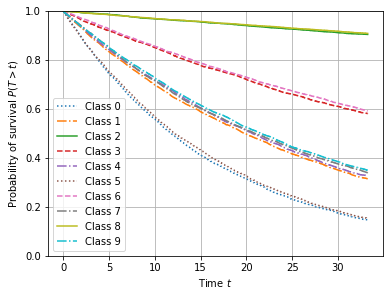

In [6]:
styles = ('-', '--', '-.', ':')

plt.figure(figsize=(6, 4.5))
for row in risk_score_assignment.itertuples():
    mask = y_train == row.Index
    coord_x, coord_y = kaplan_meier_estimator(event_train[mask], time_train[mask])
    ls = styles[row.risk_group]
    plt.step(coord_x, coord_y, where="post", label=f"Class {row.Index}", linestyle=ls)
plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()
plt.legend()

In [ ]:
#EVALUATING PREDICTIONS

In [7]:
cindex = concordance_index_censored(event_test, time_test, risk_scores[y_train.shape[0]:])

print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")

Concordance index on test data with actual risk scores: 0.705


In [ ]:
#COX'S Proportional Hazards Model

In [8]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    num_epochs : int, optional, default=1
        Number of epochs.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 num_epochs: int= 1,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        for _ in range(self.num_epochs):
            if self.shuffle:
                rnd.shuffle(index)
            for b in range(self.steps_per_epoch()):
                start = b * self.batch_size
                idx = index[start:(start + self.batch_size)]
                yield self._get_data_batch(idx)

            if not self.drop_last:
                start = self.steps_per_epoch() * self.batch_size
                idx = index[start:]
                yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> Tuple[tf.Tensor, Dict[str, tf.Tensor]]:
        ds = self._make_dataset()
        next_x, next_y = ds.make_one_shot_iterator().get_next()
        return next_x, next_y


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.get_shape().assert_same_rank(mask.get_shape())

    with tf.name_scope("logsumexp_masked", values=[risk_scores, mask]):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


def coxph_loss(event: tf.Tensor,
               riskset: tf.Tensor,
               predictions: tf.Tensor,
               weights: Union[tf.Tensor, float] = 1.0,
               scope: Optional[str] = None,
               loss_collection: str = tf.GraphKeys.LOSSES,
               reduction: str = tf.losses.Reduction.SUM_BY_NONZERO_WEIGHTS):
    """Negative partial log-likelihood of Cox's proportional
    hazards model.

    Parameters
    ----------
    event : tf.Tensor
        Binary vector where 1 indicates an event 0 censoring.
    riskset : tf.Tensor
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    predictions : tf.Tensor
        The predicted outputs. Must be a rank 2 tensor.
    weights : tf.Tensor|float
        Weight of loss. Either a scalar or a Tensor containing
        weights of each instance.
    scope : str|None
        The scope for the operations performed in computing the loss.
    loss_collection : str
        Collection to which the loss will be added.
    reduction : str
        Type of reduction to apply to loss.

    Returns
    -------
    loss : tf.Tensor
        Scalar loss.
    """
    pred_shape = predictions.get_shape()
    if pred_shape.ndims != 2:
        raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                         "be 2." % pred_shape.ndims)

    if pred_shape[1].value is None:
        raise ValueError("Last dimension of predictions must be known.")

    if pred_shape[1].value != 1:
        raise ValueError("Dimension mismatch: Last dimension of predictions "
                         "(received %s) must be 1." % pred_shape[1].value)

    if event.get_shape().ndims != pred_shape.ndims:
        raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                         "equal rank of event (received %s)" % (
            pred_shape.ndims, event.get_shape().ndims))

    if riskset.get_shape().ndims != 2:
        raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                         "be 2." % riskset.get_shape().ndims)

    with tf.name_scope(scope, 'coxph_loss', [predictions, event, riskset]) as scope:
        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope('assertions', values=[event, riskset]):
            assertions = (
                tf.assert_less_equal(event, 1.),
                tf.assert_greater_equal(event, 0.),
                tf.assert_type(riskset, tf.bool)
            )

        with tf.control_dependencies(assertions):
            # move batch dimension to the end so predictions get broadcast
            # row-wise when multiplying by riskset
            pred_t = tf.transpose(predictions)
            # compute log of sum over risk set for each row
            rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
            assert rr.get_shape().as_list() == predictions.get_shape().as_list()

            losses = tf.multiply(event, rr - predictions)
            loss = tf.losses.compute_weighted_loss(
                losses,
                weights=weights,
                scope=scope,
                loss_collection=loss_collection,
                reduction=reduction)

    return loss

In [ ]:
#Computing the loss function


In [9]:
from tensorflow.core.framework import summary_pb2


def _to_scalar_protobuf(name: str, value: Any) -> summary_pb2.Summary:
    value = float(value)
    buf = summary_pb2.Summary(value=[summary_pb2.Summary.Value(
        tag=name, simple_value=value)])
    return buf


class EvalCindexHook(tf.train.SessionRunHook):
    """Computes concordance index across one epoch.

    Collects ground truth and predicted risk score
    until session ends, i.e., `OutOfRangeError` is raised.
    The concordance index is computed across collected
    values and written to protocol buffer to display
    in TensorBoard.

    Parameters
    ----------
    label_time : tf.Tensor
        Tensor containing observed time for one batch.
    label_event_indicator : tf.Tensor
        Tensor containing event indicator for one batch.
    prediction : tf.Tensor
        Tensor containing predicted risk score for one batch.
    """

    def __init__(self,
                 label_time: tf.Tensor,
                 label_event_indicator: tf.Tensor,
                 prediction: tf.Tensor,
                 output_dir: str) -> None:
        self._label_time = label_time
        self._label_event_indicator = label_event_indicator
        self._prediction = prediction

        self._writer = tf.summary.FileWriterCache.get(output_dir)

    def begin(self) -> None:
        self._global_step_tensor = tf.train.get_or_create_global_step()
        if self._global_step_tensor is None:
            raise RuntimeError("Global step should be created.")
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }
        self._next_step = None

    def before_run(self,
                   run_context: tf.train.SessionRunContext) -> tf.train.SessionRunArgs:
        fetches = {
            "global_step": self._global_step_tensor,
            "label_time": self._label_time,
            "label_event": self._label_event_indicator,
            "prediction": self._prediction
        }
        return tf.train.SessionRunArgs(fetches=fetches)

    def after_run(self,
                  run_context: tf.train.SessionRunContext,
                  run_values: tf.train.SessionRunValues) -> None:
        global_step = run_values.results["global_step"]

        if self._next_step is None:
            self._writer.add_session_log(
                tf.SessionLog(status=tf.SessionLog.START), global_step)

        for k, v in self._data.items():
            v.append(run_values.results[k].squeeze())

        self._next_step = global_step + 1

    def _log_and_write(self, global_step: int, results: Dict[str, float]) -> None:
        msg = [f"global_step = {global_step}"]
        for k, v in results.items():
            msg.append(f"{k} = {v:.3f}")
            buf = _to_scalar_protobuf(f"metrics/{k}", v)
            self._writer.add_summary(buf, global_step=global_step)

        tf.logging.info(", ".join(msg))

    def end(self, session: tf.Session) -> None:
        if self._next_step is None:
            return

        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            data[k] = v
        self._log_and_write(self._next_step - 1, data)
        del self._data
        self._writer.flush()

In [ ]:
#Creates the Convolutional neural network for survival analysis on MNIST

In [10]:
def model_fn(features, labels, mode, params):
    is_training = mode == tf.estimator.ModeKeys.TRAIN

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
        tf.keras.layers.Dense(1, activation='linear', name='dense_3')
    ])

    risk_score = model(features, training=is_training)

    loss = None
    train_op = None
    predictions = None
    evaluation_hooks = None
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {"risk_score": risk_score}
    else:
        loss = coxph_loss(
            event=tf.expand_dims(labels["label_event"], axis=1),
            riskset=labels["label_riskset"],
            predictions=risk_score
        )

        if is_training:
            optim = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])
            gs = tf.train.get_or_create_global_step()
            train_op = tf.contrib.layers.optimize_loss(loss, gs,
                                                       learning_rate=None,
                                                       optimizer=optim)
        else:
            evaluation_hooks = [EvalCindexHook(
                label_time=labels["label_time"],
                label_event_indicator=labels["label_event"],
                prediction=risk_score,
                output_dir=Path(params["model_dir"]) / "cindex")]

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        predictions=predictions,
        evaluation_hooks=evaluation_hooks
    )


train_spec = tf.estimator.TrainSpec(
    InputFunction(x_train, time_train, event_train,
                  num_epochs=15,
                  drop_last=True,
                  shuffle=True)
)

eval_spec = tf.estimator.EvalSpec(
    InputFunction(x_test, time_test, event_test),
    steps=None,
    start_delay_secs=10,
    throttle_secs=10,
)

params = {
    "learning_rate": 0.0001,
    "model_dir": "ckpts-mnist-cnn",
}

config = tf.estimator.RunConfig(
    model_dir=params["model_dir"],
    save_checkpoints_steps=train_spec.input_fn.steps_per_epoch(),
)

estimator = tf.estimator.Estimator(model_fn, config=config, params=params)

In [ ]:
#Start Tensorboard to observe the training

In [11]:
%load_ext tensorboard.notebook

In [16]:
%tensorboard --logdir ckpts-mnist-cnn

Reusing TensorBoard on port 6006 (pid 36372), started -1 day, 23:24:30 ago. (Use '!kill 36372' to kill it.)

invalid info file: 'C:\\Users\\aishw\\AppData\\Local\\Temp\\.tensorboard-info\\pid-17648.info'
Traceback (most recent call last):
  File "C:\Users\aishw\Anaconda3\lib\site-packages\tensorboard\manager.py", line 317, in get_all
    info = _info_from_string(contents)
  File "C:\Users\aishw\Anaconda3\lib\site-packages\tensorboard\manager.py", line 158, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCJja3B0cy1tbmlzdC1jbm4iXSwiY29uZmlndXJlX2t3YXJncyI6e30sIndvcmtpbmdfZGlyZWN0b3J5IjoiQzpcXERlc2t0b3AifQ==', 'db': '', 'logdir': 'ckpts-mnist-cnn', 'path_prefix': '', 'pid': 17648, 'port': 6006, 'start_time': 1588497484, 'version': '2.1.1'}
invalid info file: 'C:\\Users\\aishw\\AppData\\Local\\Temp\\.tensorboard-info\\pid-21448.info'
Traceback (most recent call last):
  File "C:\Users\aishw\Anaconda3\lib\site-packages\tensorboard\manager.py", line 317, in get_all
    info = _inf

In [ ]:
#the training begins

In [13]:
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefi

({'loss': 1.9129063, 'global_step': 34669}, [])

In [ ]:
#predicting the survival functions

In [14]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model.coxph import BreslowEstimator


def make_pred_fn(images: np.ndarray,
                 batch_size: int = 64):
    if images.ndim == 3:
        images = images[..., np.newaxis]

    def _input_fn():
        ds = tf.data.Dataset.from_tensor_slices(images)
        ds = ds.batch(batch_size)
        next_x = ds.make_one_shot_iterator().get_next()
        return next_x, None
    return _input_fn


train_pred_fn = make_pred_fn(x_train)
train_predictions = np.array([float(pred["risk_score"])
                              for pred in estimator.predict(train_pred_fn)])

breslow = BreslowEstimator().fit(train_predictions, event_train, time_train)

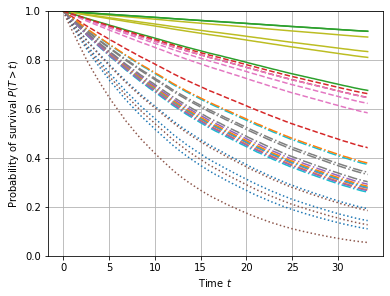

In [15]:
sample = train_test_split(x_test, y_test, event_test, time_test,
                          test_size=30, stratify=y_test, random_state=89)
x_sample, y_sample, event_sample, time_sample = sample[1::2]

sample_pred_fn = make_pred_fn(x_sample)
sample_predictions = np.array([float(pred["risk_score"])
                               for pred in estimator.predict(sample_pred_fn)])

sample_surv_fn = breslow.get_survival_function(sample_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_sample):
    risk_group = risk_score_assignment.loc[class_label, "risk_group"]
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}", linestyle=styles[risk_group])

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()